In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from realism.realism_utils import make_orderbook_for_analysis, MID_PRICE_CUTOFF
from util.plotting import liquidity_telemetry as lt

In [9]:
def get_delays_and_profits(paths):
    output = None
    slave_ids = {}
    master_ids = {}
    for path in paths:
        master_profit = None
        delays = {}
        slave_ids[path] = []
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    m_id = int(file.split('HerdMasterAgent')[1].split('.')[0])
                    master_ids[path] = m_id
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    s_id = int(file.split('HerdSlaveAgent')[1].split('.')[0])
                    slave_ids[path].append(s_id)
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output, slave_ids, master_ids

In [10]:
def get_herd_impact(paths, slaves):
    output = None
    for path in paths:
        df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
        df = df[df.EventType == 'ORDER_ACCEPTED']
        df.reset_index(inplace=True)
        temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
        temp['EventTime'] = df.EventTime
        t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
        t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
        t['SIMULATION'] = path
        t['tot_vol'] = t1.tot_vol
        
        output = t if output is None else output.append(t)
    return output

Configuration 1

In [ ]:
df = pd.read_pickle('log/prova06/herd06_seed_4153361530/HerdSlaveAgent5606.bz2', compression='bz2')
df

In [14]:
df.tail(50)

,EventType,Event
EventTime,,
2021-01-02 11:30:31.143298170,QUERY_SPREAD,5012
2021-01-02 11:30:31.381092518,QUERY_SPREAD,5071
2021-01-02 11:30:31.798196046,QUERY_SPREAD,6562
2021-01-02 11:30:32.049659805,QUERY_SPREAD,6494
2021-01-02 11:30:32.420049769,QUERY_SPREAD,5905
2021-01-02 11:30:33.108814505,QUERY_SPREAD,6624
2021-01-02 11:30:33.399997738,QUERY_SPREAD,5067
2021-01-02 11:30:33.520313192,QUERY_ORDER_STREAM,7020
2021-01-02 11:30:34.943343005,QUERY_SPREAD,5016


In [ ]:
df = pd.read_pickle('log/herd06_seed_1608637542/EXCHANGE_AGENT.bz2', compression='bz2')
df

In [7]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std           mean           std           mean   
g                                                                           
0  5.451039e+06  3.391201e+06  121466.566667  57698.744666  361788.566667   
1  2.011549e+07  5.326870e+06   81153.900000  72623.971065  372454.900000   
2  3.380075e+07  3.182857e+06   39698.833333  49934.195325  368777.700000   
3  4.504049e+07  4.113942e+06   40577.200000  34832.886657  374281.733333   
4  5.614587e+07  4.048804e+06   41396.433333  36005.700262  364933.633333   
5  6.858103e+07  4.457184e+06   34893.200000  30088.166931  373613.100000   
6  8.024152e+07  2.874059e+06   22624.900000  25490.133946  381073.000000   
7  9.225896e+07  4.061049e+06   24295.066667  24807.447112  366336.033333   

                  PERCENT            
            std      mean       std  
g                                    
0  33159.791368  0.335302  0.159015  
1  38049.902468  0.223475  0.212059  
2  39698.989359  0.105323  0.139609  
3  40390.554771  0.107873  0.097397  
4  36776.624928  0.112582  0.101762  
5  41828.035033  0.095524  0.089341  
6  40303.475642  0.059463  0.069428  
7  35891.557875  0.067591  0.071238

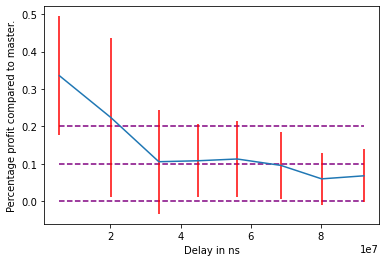

In [8]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [9]:
t = get_herd_impact(PATHS, slave_ids)

In [10]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100

In [11]:
#t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

EventTime      slave_vol                      tot_vol  \
                                 mean            std          mean   
0  2020-06-03 09:30:00   65056.500000   18622.616237  3.075332e+06   
1  2020-06-03 09:35:00   68173.000000   11706.875877  3.087636e+06   
2  2020-06-03 09:40:00   55333.333333   10528.497759  3.076544e+06   
3  2020-06-03 09:45:00   97021.500000   47698.017866  3.110875e+06   
4  2020-06-03 09:50:00   91094.166667   60949.057077  3.117700e+06   
5  2020-06-03 09:55:00   97487.666667   54341.422781  3.093468e+06   
6  2020-06-03 10:00:00   96321.333333   44364.463435  3.102780e+06   
7  2020-06-03 10:05:00  143523.666667  121717.477362  3.096773e+06   
8  2020-06-03 10:10:00  114680.833333  104704.970055  3.094282e+06   
9  2020-06-03 10:15:00   66892.833333   10474.360704  3.093510e+06   
10 2020-06-03 10:20:00  127438.166667  154727.529941  3.087380e+06   
11 2020-06-03 10:25:00  135810.166667  110662.908181  3.093535e+06   
12 2020-06-03 10:30:00  103112.333333   46415.887671  3.076005e+06   
13 2020-06-03 10:35:00   73138.000000   20669.759302  3.057914e+06   
14 2020-06-03 10:40:00   92256.333333   48124.023101  3.063902e+06   
15 2020-06-03 10:45:00   66579.333333   14473.781450  3.054601e+06   
16 2020-06-03 10:50:00   84662.666667   42238.309666  3.057113e+06   
17 2020-06-03 10:55:00   74118.166667   27382.260487  3.051767e+06   
18 2020-06-03 11:00:00   75143.333333   18679.085906  3.059774e+06   
19 2020-06-03 11:05:00   98125.666667   34336.189327  3.083382e+06   
20 2020-06-03 11:10:00  118387.166667   62203.616514  3.085537e+06   
21 2020-06-03 11:15:00   84380.833333   33535.400558  3.058472e+06   
22 2020-06-03 11:20:00  109954.000000   64623.765799  3.058929e+06   
23 2020-06-03 11:25:00  158836.500000  118228.715447  3.056339e+06   
24 2020-06-03 11:30:00  175802.500000  108383.511858  3.063480e+06   
25 2020-06-03 11:35:00  189282.833333  195898.501770  3.061668e+06   
26 2020-06-03 11:40:00  243428.166667  285681.719388  3.057813e+06   
27 2020-06-03 11:45:00  197421.500000  212534.813568  3.061826e+06   
28 2020-06-03 11:50:00  136502.500000  107294.741930  3.049381e+06   
29 2020-06-03 11:55:00  137729.166667   92100.027017  3.046840e+06   

                   PERCENT            
             std      mean       std  
0   18659.941666  2.115147  0.602409  
1    7444.292982  2.207867  0.378449  
2    4518.701805  1.798585  0.342689  
3   39934.449882  3.105247  1.473738  
4   61316.811060  2.891630  1.850682  
5   13921.183390  3.149801  1.754594  
6   35037.406152  3.099377  1.425790  
7   19550.471510  4.645689  3.961454  
8   16466.752415  3.698077  3.366457  
9   12243.770492  2.161903  0.335995  
10  15942.794934  4.137384  5.045979  
11  35131.126945  4.390631  3.594703  
12  53719.730760  3.336429  1.443812  
13  17784.778283  2.389520  0.664830  
14  26465.862584  3.010427  1.577929  
15   9826.194279  2.179109  0.471645  
16   8059.331273  2.767076  1.373717  
17   7766.003013  2.429427  0.901292  
18  17920.497772  2.454198  0.599942  
19  35318.748526  3.173686  1.086968  
20  30703.800282  3.827424  1.990091  
21  10013.782038  2.759283  1.100215  
22   7946.983218  3.590834  2.099881  
23  13253.629385  5.198660  3.877817  
24  21480.933127  5.740336  3.552085  
25  21226.727978  6.197649  6.441345  
26  39474.731591  7.961758  9.359453  
27   9205.967623  6.436589  6.918264  
28  31850.639353  4.484038  3.536028  
29  19015.924562  4.517435  3.012289

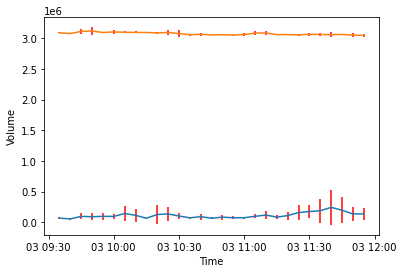

In [12]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

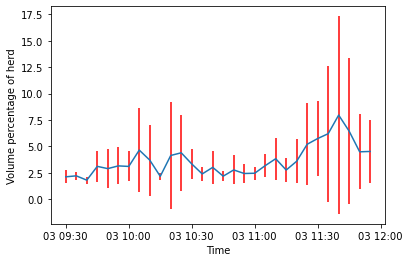

In [13]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [23]:
# Herd10 config

PATHS = []
for file in os.listdir('log'):
    if 'herd13' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,7963899,-28,368,log/herd13_seed_3421126067,-0.076087
1,27054140,-336,368,log/herd13_seed_3421126067,-0.913043
2,37364373,-182,368,log/herd13_seed_3421126067,-0.494565
3,39855390,337,240,log/herd13_seed_1608637542,1.404167
4,61399605,-336,368,log/herd13_seed_3421126067,-0.913043
...,...,...,...,...,...
115,8465902077,79,240,log/herd13_seed_1608637542,0.329167
116,11230228681,26,240,log/herd13_seed_1608637542,0.108333
117,11690749719,-74,368,log/herd13_seed_3421126067,-0.201087
118,15561662472,15,240,log/herd13_seed_1608637542,0.062500


In [5]:
# Herd03 config

PATHS = []
for file in os.listdir('log'):
    if 'herd03' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,286883.0,1234.0,6800,log/herd03_seed_422396446,0.181471
1,342187.0,8186.0,7072,log/herd03_seed_3842306364,1.157523
2,428872.0,5448.0,5555,log/herd03_seed_1345499493,0.980738
3,850660.0,3344.0,7072,log/herd03_seed_3842306364,0.472851
4,1003303.0,9093.0,9971,log/herd03_seed_602957303,0.911945
...,...,...,...,...,...
5995,998611239.0,1695.0,6065,log/herd03_seed_2876537340,0.279472
5996,998738060.0,5361.0,7940,log/herd03_seed_1923688040,0.675189
5997,998973671.0,2626.0,4764,log/herd03_seed_1261063143,0.551217
5998,999444814.0,8783.0,6512,log/herd03_seed_1768615473,1.348741


In [16]:
print(f'{10:02d}')

10


In [7]:
df['g'] = df.index//300
temp_1 = df.groupby('g').agg(['mean', 'std'])
temp_1

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.599193e+07  1.497188e+07  9457.496667  5778.447932   9390.543333   
1   7.482449e+07  1.418810e+07  8971.156667  4933.225749   8969.966667   
2   1.237401e+08  1.472173e+07  8680.096667  4941.580985   8983.770000   
3   1.765181e+08  1.430960e+07  8897.710000  5517.329115   9313.080000   
4   2.239471e+08  1.459970e+07  8916.420000  4986.964285   9494.933333   
5   2.772314e+08  1.485603e+07  8849.510000  4914.496772   9679.826667   
6   3.308337e+08  1.567792e+07  8173.880000  4581.363629   9346.656667   
7   3.809213e+08  1.420441e+07  7806.470000  4648.578468   8911.983333   
8   4.282417e+08  1.397103e+07  8138.876667  5012.520901   9368.830000   
9   4.748018e+08  1.233859e+07  8366.826667  5644.717292   9406.496667   
10  5.237470e+08  1.624924e+07  7119.570000  4422.693576   8880.450000   
11  5.794474e+08  1.542855e+07  6802.776667  3617.596336   8823.633333   
12  6.296114e+08  1.369760e+07  6903.563333  4774.717785   8990.036667   
13  6.802370e+08  1.480414e+07  6822.043333  4241.086362   9053.670000   
14  7.294241e+08  1.261331e+07  6324.733333  3735.629622   8863.393333   
15  7.745879e+08  1.380868e+07  6529.426667  4623.596408   9019.036667   
16  8.258070e+08  1.542038e+07  6616.430000  4576.658562   9233.403333   
17  8.771747e+08  1.293181e+07  6988.800000  5137.023542   9323.496667   
18  9.256565e+08  1.473236e+07  6877.746667  4985.046206   9593.343333   
19  9.748717e+08  1.428819e+07  6740.380000  5537.769514   9986.850000   

                  PERCENT            
            std      mean       std  
g                                    
0   5341.543147  1.014528  0.324281  
1   4100.095029  0.999235  0.308430  
2   4682.379673  0.973812  0.329942  
3   5176.908698  0.955516  0.383197  
4   4969.716060  0.955494  0.321042  
5   4958.589690  0.924929  0.290633  
6   4907.671782  0.886583  0.311998  
7   4681.188495  0.892054  0.406446  
8   4752.195611  0.862762  0.299817  
9   4852.364519  0.897599  0.482215  
10  4143.496237  0.808658  0.368183  
11  3668.873450  0.772290  0.313708  
12  5010.610723  0.770382  0.384129  
13  4074.939808  0.740740  0.284066  
14  4159.098342  0.714143  0.303871  
15  4470.089540  0.717423  0.361516  
16  4571.399770  0.694278  0.317925  
17  4142.323165  0.729346  0.410760  
18  4574.674731  0.704226  0.408053  
19  6281.402821  0.663835  0.358614

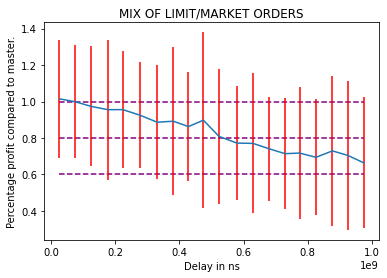

In [8]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
plt.title('MIX OF LIMIT/MARKET ORDERS')
xmin, xmax= temp_1.DELAY['mean'].min(), temp_1.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp_1.DELAY['mean'], temp_1.PERCENT['mean'], yerr=temp_1.PERCENT['std'], ecolor='red')  
plt.show()

In [9]:
# Herd04 config

PATHS = []
for file in os.listdir('log'):
    if 'herd04' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,286883.0,1618.0,7463,log/herd04_seed_422396446,0.216803
1,342187.0,8117.0,7959,log/herd04_seed_3842306364,1.019852
2,428872.0,5548.0,5672,log/herd04_seed_1345499493,0.978138
3,850660.0,5929.0,7959,log/herd04_seed_3842306364,0.744943
4,1003303.0,10293.0,10547,log/herd04_seed_602957303,0.975917
...,...,...,...,...,...
5995,998611239.0,1698.0,4981,log/herd04_seed_2876537340,0.340895
5996,998738060.0,5686.0,6857,log/herd04_seed_1923688040,0.829226
5997,998973671.0,9345.0,8345,log/herd04_seed_1261063143,1.119832
5998,999444814.0,13219.0,5419,log/herd04_seed_1768615473,2.439380


In [10]:
df['g'] = df.index//300
temp_2 = df.groupby('g').agg(['mean', 'std'])
temp_2

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.599193e+07  1.497188e+07  9225.273333  5546.062491   9132.676667   
1   7.482449e+07  1.418810e+07  8510.350000  4482.921686   8578.983333   
2   1.237401e+08  1.472173e+07  8601.390000  5149.134640   8710.060000   
3   1.765181e+08  1.430960e+07  9181.946667  6056.928642   9039.710000   
4   2.239471e+08  1.459970e+07  9043.823333  5916.640942   9080.283333   
5   2.772314e+08  1.485603e+07  9259.386667  5865.666299   9367.860000   
6   3.308337e+08  1.567792e+07  8614.353333  5474.913255   8916.856667   
7   3.809213e+08  1.420441e+07  8906.850000  6737.910613   8679.253333   
8   4.282417e+08  1.397103e+07  9684.103333  7038.048660   9151.576667   
9   4.748018e+08  1.233859e+07  8989.736667  6339.889451   8918.936667   
10  5.237470e+08  1.624924e+07  8118.053333  5544.413230   8516.616667   
11  5.794474e+08  1.542855e+07  8265.410000  5311.062595   8583.626667   
12  6.296114e+08  1.369760e+07  8425.623333  6223.261916   8617.473333   
13  6.802370e+08  1.480414e+07  8087.576667  4865.851556   8625.180000   
14  7.294241e+08  1.261331e+07  8297.576667  5595.637216   8704.853333   
15  7.745879e+08  1.380868e+07  8286.036667  5434.570692   8700.926667   
16  8.258070e+08  1.542038e+07  8375.730000  6128.606646   8925.973333   
17  8.771747e+08  1.293181e+07  9108.140000  6178.277684   8917.400000   
18  9.256565e+08  1.473236e+07  8937.450000  7472.431445   9134.293333   
19  9.748717e+08  1.428819e+07  8631.570000  6653.075279   9516.860000   

                  PERCENT            
            std      mean       std  
g                                    
0   5053.850992  1.015329  0.322493  
1   4050.085285  0.992320  0.268130  
2   4515.663388  0.981005  0.316073  
3   4969.031826  0.999101  0.400415  
4   4852.283068  0.983403  0.353306  
5   4779.487356  0.985976  0.390688  
6   4707.835285  0.964605  0.387759  
7   4526.414146  1.014091  0.528746  
8   4662.449865  1.039920  0.509493  
9   4664.160633  0.999510  0.529656  
10  4029.286768  0.957364  0.463166  
11  3788.132458  0.954960  0.435337  
12  4741.219168  0.957953  0.470098  
13  3992.945346  0.942973  0.400581  
14  4128.536741  0.946961  0.427590  
15  4423.395741  0.963756  0.470902  
16  4532.323475  0.923259  0.461986  
17  4034.185601  1.030683  0.564829  
18  4449.804684  0.952537  0.562920  
19  5897.470108  0.918803  0.510648

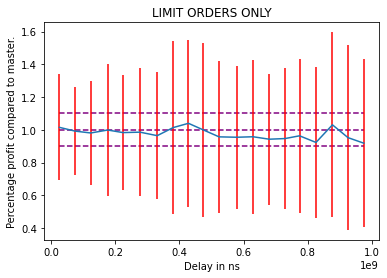

In [11]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
plt.title('LIMIT ORDERS ONLY')
xmin, xmax= temp_2.DELAY['mean'].min(), temp_2.DELAY['mean'].max()
plt.hlines(y=[1.1, 0.9, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp_2.DELAY['mean'], temp_2.PERCENT['mean'], yerr=temp_2.PERCENT['std'], ecolor='red')  
plt.show()

In [12]:
# Herd05 config

PATHS = []
for file in os.listdir('log'):
    if 'herd05' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,286883.0,1104.0,7016,log/herd05_seed_422396446,0.157355
1,342187.0,9624.0,8717,log/herd05_seed_3842306364,1.104050
2,428872.0,5725.0,5891,log/herd05_seed_1345499493,0.971821
3,850660.0,4929.0,8717,log/herd05_seed_3842306364,0.565447
4,1003303.0,10742.0,11153,log/herd05_seed_602957303,0.963149
...,...,...,...,...,...
5995,998611239.0,1114.0,5245,log/herd05_seed_2876537340,0.212393
5996,998738060.0,4902.0,7662,log/herd05_seed_1923688040,0.639781
5997,998973671.0,871.0,4913,log/herd05_seed_1261063143,0.177285
5998,999444814.0,3021.0,5802,log/herd05_seed_1768615473,0.520683


In [13]:
df['g'] = df.index//300
temp_3 = df.groupby('g').agg(['mean', 'std'])
temp_3

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.599193e+07  1.497188e+07  9990.336667  5741.881308  10101.750000   
1   7.482449e+07  1.418810e+07  9355.753333  4544.614845   9567.386667   
2   1.237401e+08  1.472173e+07  9212.356667  5139.416636   9822.273333   
3   1.765181e+08  1.430960e+07  9051.213333  5414.094050  10017.413333   
4   2.239471e+08  1.459970e+07  9018.566667  4681.905611  10212.950000   
5   2.772314e+08  1.485603e+07  8808.143333  4741.854542  10455.036667   
6   3.308337e+08  1.567792e+07  8108.420000  4494.472516  10032.043333   
7   3.809213e+08  1.420441e+07  7864.870000  4717.238622   9686.703333   
8   4.282417e+08  1.397103e+07  8005.206667  4602.529878  10188.216667   
9   4.748018e+08  1.233859e+07  7911.943333  4869.180218  10079.066667   
10  5.237470e+08  1.624924e+07  6801.973333  3870.533437   9485.106667   
11  5.794474e+08  1.542855e+07  6587.536667  3745.787132   9561.393333   
12  6.296114e+08  1.369760e+07  6679.793333  4915.339226   9652.363333   
13  6.802370e+08  1.480414e+07  6327.866667  4072.300200   9675.950000   
14  7.294241e+08  1.261331e+07  6109.713333  4013.079456   9521.336667   
15  7.745879e+08  1.380868e+07  6090.523333  4310.963994   9590.440000   
16  8.258070e+08  1.542038e+07  6025.270000  4051.162058   9943.960000   
17  8.771747e+08  1.293181e+07  6220.176667  4481.502752   9876.850000   
18  9.256565e+08  1.473236e+07  6337.163333  4745.305102  10184.273333   
19  9.748717e+08  1.428819e+07  6161.466667  5526.115398  10558.086667   

                  PERCENT            
            std      mean       std  
g                                    
0   5564.329895  1.001233  0.352156  
1   4109.254098  0.987965  0.397888  
2   4910.986058  0.948569  0.398910  
3   5403.139774  0.902133  0.400071  
4   5178.553422  0.919246  0.452952  
5   5144.485400  0.851895  0.292961  
6   5132.477318  0.822389  0.377076  
7   4871.578992  0.826509  0.444454  
8   4892.607735  0.785976  0.313561  
9   5033.617437  0.802126  0.493169  
10  4161.826986  0.727928  0.392632  
11  3808.329075  0.675539  0.338298  
12  5174.061820  0.691193  0.477062  
13  4177.825244  0.632303  0.270108  
14  4166.186500  0.640682  0.438353  
15  4579.165670  0.623497  0.399079  
16  4607.585808  0.583187  0.264310  
17  4164.932366  0.599458  0.378649  
18  4616.520985  0.609899  0.469768  
19  6637.229287  0.557118  0.357242

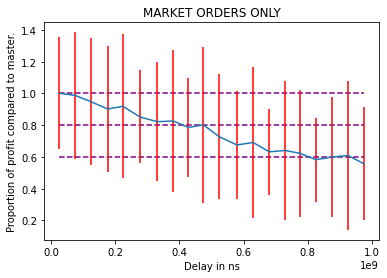

In [14]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('MARKET ORDERS ONLY')
xmin, xmax= temp_3.DELAY['mean'].min(), temp_3.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp_3.DELAY['mean'], temp_3.PERCENT['mean'], yerr=temp_3.PERCENT['std'], ecolor='red')  
plt.show()

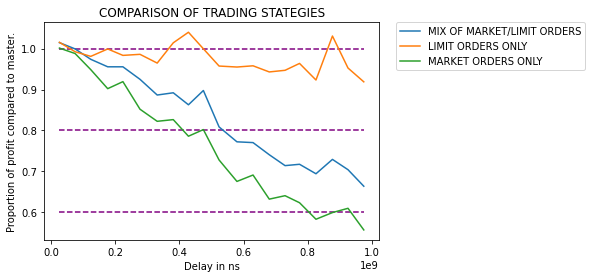

In [15]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('COMPARISON OF TRADING STATEGIES')
xmin, xmax= temp_3.DELAY['mean'].min(), temp_3.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.plot(temp_1.DELAY['mean'], temp_1.PERCENT['mean'], label="MIX OF MARKET/LIMIT ORDERS")
plt.plot(temp_2.DELAY['mean'], temp_2.PERCENT['mean'], label="LIMIT ORDERS ONLY")
plt.plot(temp_3.DELAY['mean'], temp_3.PERCENT['mean'], label="MARKET ORDERS ONLY")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [16]:
# Herd06 config

PATHS = []
for file in os.listdir('log/log_mazza/log'):
    if 'herd06' in file:
        PATHS.append(f'log//log_mazza/log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,276084.0,3285.0,3227,log//log_mazza/log/herd06_seed_4222944499,1.017973
1,328180.0,8924.0,9053,log//log_mazza/log/herd06_seed_3143890026,0.985751
2,415963.0,3796.0,3751,log//log_mazza/log/herd06_seed_3905501389,1.011997
3,622998.0,8983.0,8821,log//log_mazza/log/herd06_seed_669991378,1.018365
4,967709.0,12427.0,8507,log//log_mazza/log/herd06_seed_2655947709,1.460797
...,...,...,...,...,...
2995,996628195.0,-277.0,4080,log//log_mazza/log/herd06_seed_3100961111,-0.067892
2996,997408115.0,5942.0,8238,log//log_mazza/log/herd06_seed_56972561,0.721292
2997,997453260.0,2873.0,3751,log//log_mazza/log/herd06_seed_3905501389,0.765929
2998,997989230.0,4507.0,4745,log//log_mazza/log/herd06_seed_780932287,0.949842


In [17]:
df['g'] = df.index//150
temp_4 = df.groupby('g').agg(['mean', 'std'])
temp_4

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.474669e+07  1.418476e+07  9268.900000  7243.261730   9273.126667   
1   6.951442e+07  1.213205e+07  8738.293333  6783.270885   8897.693333   
2   1.190888e+08  1.457062e+07  8062.880000  4402.015275   8668.513333   
3   1.704885e+08  1.463828e+07  8002.853333  5558.116177   8435.840000   
4   2.203876e+08  1.526933e+07  8176.740000  5585.413514   8613.140000   
5   2.680660e+08  1.318766e+07  8222.726667  5703.116080   8929.873333   
6   3.173601e+08  1.381527e+07  8772.566667  7202.813067   9069.120000   
7   3.642047e+08  1.288525e+07  7601.213333  5408.958332   8786.526667   
8   4.093244e+08  1.409863e+07  8135.960000  5788.659907   9203.373333   
9   4.545861e+08  1.401341e+07  7578.446667  7050.474753   8584.080000   
10  5.095872e+08  1.708810e+07  7341.913333  4453.606705   8428.180000   
11  5.605996e+08  1.410518e+07  8441.406667  8346.000118   9728.686667   
12  6.097172e+08  1.378120e+07  7659.253333  5349.123645   8905.173333   
13  6.626212e+08  1.667249e+07  7106.373333  5585.769107   8749.380000   
14  7.138286e+08  1.245182e+07  6839.813333  4458.012844   8234.060000   
15  7.608138e+08  1.546030e+07  7266.106667  5715.655419   8896.673333   
16  8.152168e+08  1.450923e+07  7693.526667  6498.537870   9813.133333   
17  8.637364e+08  1.455258e+07  7815.446667  6206.253669   9424.920000   
18  9.195128e+08  1.591001e+07  7701.606667  7104.135206   9206.806667   
19  9.720502e+08  1.613713e+07  6386.846667  4451.681380   8461.900000   

                  PERCENT            
            std      mean       std  
g                                    
0   6419.741837  1.000038  0.322518  
1   5923.323326  0.987553  0.340276  
2   3889.737204  0.935534  0.291716  
3   4903.502841  0.947129  0.327189  
4   5038.279268  0.931825  0.296106  
5   5515.498120  0.927175  0.313065  
6   6724.849981  0.971469  0.366514  
7   5073.716922  0.871415  0.375089  
8   5602.255963  0.881920  0.355630  
9   6581.783722  0.870540  0.434947  
10  4301.616133  0.879784  0.360236  
11  8432.369946  0.849541  0.344916  
12  5389.088197  0.861723  0.322916  
13  5079.673199  0.792275  0.378325  
14  3964.939805  0.825318  0.412666  
15  5245.757742  0.821404  0.443534  
16  6656.416389  0.797177  0.409641  
17  6167.905005  0.829350  0.385878  
18  6726.372399  0.818891  0.493655  
19  4637.889560  0.758683  0.364187

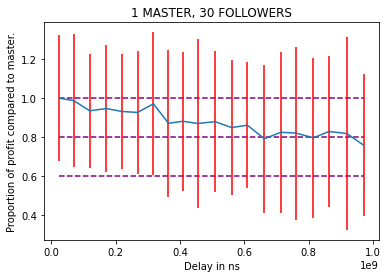

In [18]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('1 MASTER, 30 FOLLOWERS')
xmin, xmax= temp_4.DELAY['mean'].min(), temp_4.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp_4.DELAY['mean'], temp_4.PERCENT['mean'], yerr=temp_4.PERCENT['std'], ecolor='red')  
plt.show()

In [19]:
# Herd07 config

PATHS = []
for file in os.listdir('log/log_mazza/log'):
    if 'herd07' in file:
        PATHS.append(f'log//log_mazza/log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,3.642399e+06,6201.0,4586,log//log_mazza/log/herd07_seed_2938758483,1.352159
1,3.806973e+06,6253.0,5730,log//log_mazza/log/herd07_seed_199502978,1.091274
2,9.754252e+06,7803.0,7700,log//log_mazza/log/herd07_seed_2126768636,1.013377
3,1.329712e+07,4694.0,4716,log//log_mazza/log/herd07_seed_4147358011,0.995335
4,1.382979e+07,9837.0,8543,log//log_mazza/log/herd07_seed_249467210,1.151469
...,...,...,...,...,...
11995,2.499134e+10,2687.0,10272,log//log_mazza/log/herd07_seed_1972458954,0.261585
11996,2.499204e+10,626.0,6865,log//log_mazza/log/herd07_seed_2845511527,0.091187
11997,2.499487e+10,944.0,6142,log//log_mazza/log/herd07_seed_780932287,0.153696
11998,2.499617e+10,-1785.0,5911,log//log_mazza/log/herd07_seed_1679592528,-0.301979


In [20]:
df['g'] = df.index//600
temp_5 = df.groupby('g').agg(['mean', 'std'])
temp_5

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   6.493962e+08  3.634820e+08  8569.860000  5371.715274   8581.011667   
1   1.834759e+09  3.418038e+08  7941.913333  5488.497446   8698.753333   
2   3.080111e+09  3.688741e+08  7813.481667  6294.563736   9157.586667   
3   4.359883e+09  3.681555e+08  6974.991667  4873.875440   8765.635000   
4   5.590896e+09  3.173753e+08  6516.701667  4804.848731   8576.505000   
5   6.816860e+09  3.796897e+08  5887.415000  4092.449806   8307.810000   
6   8.069259e+09  3.647003e+08  5492.515000  4496.913945   8271.836667   
7   9.354370e+09  3.654075e+08  5384.328333  4507.277645   8650.890000   
8   1.056495e+10  3.429600e+08  4825.463333  4357.514214   8207.373333   
9   1.179088e+10  3.417745e+08  4882.985000  4352.528699   8774.678333   
10  1.303018e+10  3.620399e+08  4613.450000  4381.575819   8899.258333   
11  1.429567e+10  3.502935e+08  4240.770000  4140.961487   8664.820000   
12  1.554694e+10  3.772947e+08  4121.446667  4161.259168   8817.421667   
13  1.681305e+10  3.720232e+08  3749.035000  4086.879413   8448.103333   
14  1.810429e+10  3.707701e+08  3727.900000  4342.086464   8700.348333   
15  1.941150e+10  3.699781e+08  3596.441667  4081.154178   8879.591667   
16  2.068299e+10  3.557778e+08  2999.918333  3743.568173   8743.510000   
17  2.185313e+10  3.235630e+08  3114.545000  4177.215896   9177.313333   
18  2.302611e+10  3.782573e+08  2914.003333  4536.011879   8849.875000   
19  2.437583e+10  3.805443e+08  2573.968333  3682.921671   8901.478333   

                  PERCENT            
            std      mean       std  
g                                    
0   5023.058240  1.006964  0.264828  
1   5015.352558  0.917559  0.304706  
2   6284.489922  0.857373  0.327126  
3   5207.112078  0.806375  0.300258  
4   4918.454247  0.756323  0.268501  
5   4560.150246  0.712215  0.314262  
6   4552.801112  0.656907  0.362237  
7   5177.638787  0.612883  0.328746  
8   4503.665049  0.569555  0.347303  
9   5563.518703  0.551633  0.351020  
10  5348.695772  0.501467  0.337144  
11  5059.032325  0.487315  0.346623  
12  5278.596389  0.453085  0.356819  
13  5090.595267  0.421500  0.356887  
14  5078.559940  0.396195  0.364635  
15  5935.380130  0.383694  0.395990  
16  5631.766927  0.306486  0.316063  
17  6186.277627  0.298536  0.344226  
18  6096.335126  0.287511  0.368657  
19  5353.814458  0.245812  0.328687

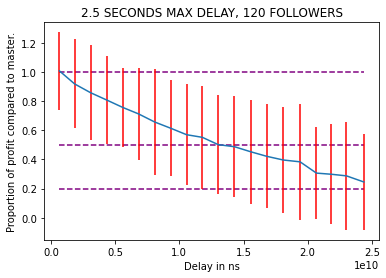

In [21]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('2.5 SECONDS MAX DELAY, 120 FOLLOWERS')
xmin, xmax= temp_5.DELAY['mean'].min(), temp_5.DELAY['mean'].max()
plt.hlines(y=[0.2, 0.5, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp_5.DELAY['mean'], temp_5.PERCENT['mean'], yerr=temp_5.PERCENT['std'], ecolor='red')  
plt.show()

In [22]:
# Herd08 config

PATHS = []
for file in os.listdir('log/log_mazza/log'):
    if 'herd08' in file:
        PATHS.append(f'log//log_mazza/log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,7.731851e+07,6558.0,7437,log//log_mazza/log/herd08_seed_793943861,0.881807
1,9.249927e+07,11310.0,11816,log//log_mazza/log/herd08_seed_2253890010,0.957177
2,1.024627e+08,5294.0,5114,log//log_mazza/log/herd08_seed_4147358011,1.035197
3,1.075867e+08,7467.0,7854,log//log_mazza/log/herd08_seed_893102645,0.950726
4,1.230754e+08,9618.0,8124,log//log_mazza/log/herd08_seed_419498548,1.183900
...,...,...,...,...,...
2995,3.992916e+10,14743.0,17668,log//log_mazza/log/herd08_seed_2438254339,0.834446
2996,3.995202e+10,869.0,6637,log//log_mazza/log/herd08_seed_242285876,0.130933
2997,3.996287e+10,5155.0,11317,log//log_mazza/log/herd08_seed_56972561,0.455509
2998,3.997480e+10,2941.0,7227,log//log_mazza/log/herd08_seed_3578544903,0.406946


In [23]:
df['g'] = df.index//150
temp_6 = df.groupby('g').agg(['mean', 'std'])
temp_6

DELAY                SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std          mean          std          mean   
g                                                                         
0   9.642603e+08  4.852268e+08  11323.566667  8257.420494   9681.540000   
1   2.708090e+09  6.049346e+08  10095.853333  6475.803866   9733.440000   
2   4.734880e+09  5.464093e+08   9740.786667  5839.369277   9678.046667   
3   6.580920e+09  5.938854e+08   8277.506667  5340.041790   9256.646667   
4   8.633626e+09  5.489882e+08   8812.133333  5064.088290  10030.406667   
5   1.059846e+10  5.671402e+08   8036.966667  5529.729912   9190.673333   
6   1.261048e+10  6.204154e+08   8182.946667  6851.676919   9682.446667   
7   1.452217e+10  5.261890e+08   8561.453333  6819.678297   9468.246667   
8   1.626304e+10  5.125910e+08   8418.153333  6981.172972  10349.826667   
9   1.843121e+10  6.531926e+08   7687.960000  6531.432343   9432.560000   
10  2.062854e+10  5.284977e+08   7407.633333  6605.915266   9286.233333   
11  2.249100e+10  4.843940e+08   8116.766667  7353.449817  10388.093333   
12  2.454656e+10  6.647009e+08   7530.426667  5349.474933  10368.893333   
13  2.677672e+10  6.145960e+08   6514.413333  5995.442538   9718.940000   
14  2.897478e+10  6.081249e+08   6757.860000  5755.400249  10122.473333   
15  3.100925e+10  5.866157e+08   6201.406667  5325.207066  10026.200000   
16  3.304902e+10  6.156831e+08   6262.220000  5141.347656   9854.126667   
17  3.502923e+10  6.169425e+08   6369.633333  6092.058886   9554.853333   
18  3.709226e+10  5.908049e+08   6025.780000  5305.652580  10092.860000   
19  3.902014e+10  5.727957e+08   6455.493333  5865.717141   9999.693333   

                  PERCENT            
            std      mean       std  
g                                    
0   5534.930781  1.239357  0.702169  
1   6842.887519  1.133797  0.472873  
2   6069.092247  1.079652  0.445619  
3   6105.056559  0.961706  0.387756  
4   5357.306923  0.934460  0.458867  
5   6162.799045  0.995823  0.662698  
6   7181.617190  0.975213  0.622515  
7   6029.701625  0.948123  0.566969  
8   7312.055891  0.860784  0.626345  
9   6099.719052  0.822255  0.629769  
10  5488.111814  0.791933  0.487925  
11  8022.978311  0.837867  0.562562  
12  6276.796798  0.712975  0.473055  
13  7476.013560  0.763576  0.767132  
14  7571.612247  0.654792  0.508696  
15  7232.838754  0.670373  0.484685  
16  5584.571993  0.631426  0.566706  
17  6498.385889  0.682428  0.751091  
18  7131.411231  0.597353  0.543614  
19  6639.716190  0.644689  0.558593

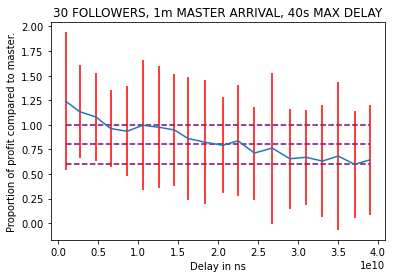

In [24]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('30 FOLLOWERS, 1m MASTER ARRIVAL, 40s MAX DELAY')
xmin, xmax= temp_6.DELAY['mean'].min(), temp_6.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp_6.DELAY['mean'], temp_6.PERCENT['mean'], yerr=temp_6.PERCENT['std'], ecolor='red')  
plt.show()

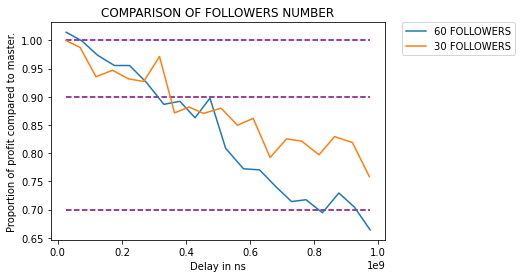

In [25]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('COMPARISON OF FOLLOWERS NUMBER')
xmin, xmax= temp_3.DELAY['mean'].min(), temp_3.DELAY['mean'].max()
plt.hlines(y=[0.7, 0.9, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.plot(temp_1.DELAY['mean'], temp_1.PERCENT['mean'], label="60 FOLLOWERS")
plt.plot(temp_4.DELAY['mean'], temp_4.PERCENT['mean'], label="30 FOLLOWERS")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

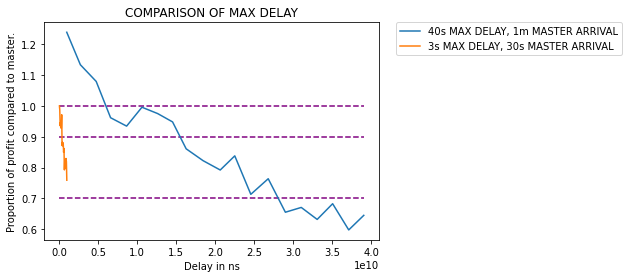

In [26]:
plt.xlabel('Delay in ns')
plt.ylabel('Proportion of profit compared to master.')
plt.title('COMPARISON OF MAX DELAY')
xmin, xmax= temp_4.DELAY['mean'].min(), temp_6.DELAY['mean'].max()
plt.hlines(y=[0.7, 0.9, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.plot(temp_6.DELAY['mean'], temp_6.PERCENT['mean'], label="40s MAX DELAY, 1m MASTER ARRIVAL")
plt.plot(temp_4.DELAY['mean'], temp_4.PERCENT['mean'], label="3s MAX DELAY, 30s MASTER ARRIVAL")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()